## Importing Stuff

In [2]:
anno_path = "/home/maelic/Documents/PhD/Datasets/VisualGenome/annotations/rel.json"
import json
import os

with open(anno_path, 'r') as f:
    data = json.load(f)

print(data.keys())
print(data['val'][0])

dict_keys(['train', 'val', 'test', 'rel_categories'])


KeyError: 'annotations'

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import time
import onnxruntime
import numpy as np
import torch
from models import build_model
from argparse import Namespace


# Utils for bounding boxes

In [2]:
def box_cxcywh_to_xyxy(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = np.stack((x1, y1, x2, y2), axis=-1)
    return boxes

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * np.array([img_w, img_h, img_w, img_h], dtype=np.float32)
    return b

In [2]:
# VG classes
CLASSES = [ 'N/A', 'airplane', 'animal', 'arm', 'bag', 'banana', 'basket', 'beach', 'bear', 'bed', 'bench', 'bike',
            'bird', 'board', 'boat', 'book', 'boot', 'bottle', 'bowl', 'box', 'boy', 'branch', 'building',
            'bus', 'cabinet', 'cap', 'car', 'cat', 'chair', 'child', 'clock', 'coat', 'counter', 'cow', 'cup',
            'curtain', 'desk', 'dog', 'door', 'drawer', 'ear', 'elephant', 'engine', 'eye', 'face', 'fence',
            'finger', 'flag', 'flower', 'food', 'fork', 'fruit', 'giraffe', 'girl', 'glass', 'glove', 'guy',
            'hair', 'hand', 'handle', 'hat', 'head', 'helmet', 'hill', 'horse', 'house', 'jacket', 'jean',
            'kid', 'kite', 'lady', 'lamp', 'laptop', 'leaf', 'leg', 'letter', 'light', 'logo', 'man', 'men',
            'motorcycle', 'mountain', 'mouth', 'neck', 'nose', 'number', 'orange', 'pant', 'paper', 'paw',
            'people', 'person', 'phone', 'pillow', 'pizza', 'plane', 'plant', 'plate', 'player', 'pole', 'post',
            'pot', 'racket', 'railing', 'rock', 'roof', 'room', 'screen', 'seat', 'sheep', 'shelf', 'shirt',
            'shoe', 'short', 'sidewalk', 'sign', 'sink', 'skateboard', 'ski', 'skier', 'sneaker', 'snow',
            'sock', 'stand', 'street', 'surfboard', 'table', 'tail', 'tie', 'tile', 'tire', 'toilet', 'towel',
            'tower', 'track', 'train', 'tree', 'truck', 'trunk', 'umbrella', 'vase', 'vegetable', 'vehicle',
            'wave', 'wheel', 'window', 'windshield', 'wing', 'wire', 'woman', 'zebra']

REL_CLASSES = ['__background__', 'above', 'across', 'against', 'along', 'and', 'at', 'attached to', 'behind',
            'belonging to', 'between', 'carrying', 'covered in', 'covering', 'eating', 'flying in', 'for',
            'from', 'growing on', 'hanging from', 'has', 'holding', 'in', 'in front of', 'laying on',
            'looking at', 'lying on', 'made of', 'mounted on', 'near', 'of', 'on', 'on back of', 'over',
            'painted on', 'parked on', 'part of', 'playing', 'riding', 'says', 'sitting on', 'standing on',
            'to', 'under', 'using', 'walking in', 'walking on', 'watching', 'wearing', 'wears', 'with']

In [3]:
transform = T.Compose([
    T.Resize([480,640]),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
args = Namespace(lr_backbone=1e-05, dataset='vg', img_path='demo/vg1.jpg', backbone='resnet50', dilation=False, position_embedding='sine', 
enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_entities=100, num_triplets=200, pre_norm=False, 
aux_loss=True, device='cuda', resume='ckpt/checkpoint0149.pth', set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, set_iou_threshold=0.7, 
bbox_loss_coef=5, giou_loss_coef=2, rel_loss_coef=1, eos_coef=0.1, return_interm_layers=False)
model, _, _ = build_model(args)
ckpt = torch.load(args.resume)
model.load_state_dict(ckpt['model'])
model.eval()

batch_size = 1

dummy_input = torch.randn(1, 3, 480, 640)

KeyboardInterrupt: 

In [6]:
# propagate through the model
outputs = model(dummy_input)

# # Export the model
torch.onnx.export(model,               # model being run
                dummy_input,               # model input (or a tuple for multiple inputs)
                "normal_resolution.onnx",   # where to save the model (can be a file or file-like object)
                export_params=True,        # store the trained parameter weights inside the model file
                opset_version=11,          # the ONNX version to export the model to
                do_constant_folding=True,  # whether to execute constant folding for optimization
                input_names = ['input'],   # the model's input names
                output_names = ['output'], # the model's output names
                dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})


/home/maelic/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/maelic/Documents/PhD/ModelZoo/SGG/RelTR/util/misc.py:337: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  max_size_i = torch.max(torch.stack([img.shape[i] for img in tensor_list]).to(torch.float32)).to(torch.int64)
/home/maelic/Documents/PhD/ModelZoo/SGG/RelTR/util/mi

KeyboardInterrupt: 

In [7]:
img_path = args.img_path
im = Image.open(img_path)
img=transform(im).unsqueeze_(0).cpu().detach().numpy()


# Do an inference to check if everything is ok

In [8]:
def post_processing(ort_outs):
    outputs = {}
    outputs['pred_logits'] = torch.tensor(ort_outs[0])
    outputs['pred_boxes'] = torch.tensor(ort_outs[1])
    outputs['sub_logits'] = torch.tensor(ort_outs[2])
    outputs['sub_boxes'] = torch.tensor(ort_outs[3])
    outputs['obj_logits'] = torch.tensor(ort_outs[4])
    outputs['obj_boxes'] = torch.tensor(ort_outs[5])
    outputs['rel_logits'] = torch.tensor(ort_outs[6])

    print("Exported model has been tested with ONNXRuntime, and the result looks good!")

    # keep only predictions with 0.+ confidence
    probas = outputs['rel_logits'].softmax(-1)[0, :, :-1]
    probas_sub = outputs['sub_logits'].softmax(-1)[0, :, :-1]
    probas_obj = outputs['obj_logits'].softmax(-1)[0, :, :-1]
    keep = torch.logical_and(probas.max(-1).values > 0.3, torch.logical_and(probas_sub.max(-1).values > 0.3,
                                                                            probas_obj.max(-1).values > 0.3))

    # convert boxes from [0; 1] to image scales
    sub_bboxes_scaled = rescale_bboxes(outputs['sub_boxes'][0, keep], im.size)
    obj_bboxes_scaled = rescale_bboxes(outputs['obj_boxes'][0, keep], im.size)

    topk = 10
    keep_queries = torch.nonzero(keep, as_tuple=True)[0]
    indices = torch.argsort(-probas[keep_queries].max(-1)[0] * probas_sub[keep_queries].max(-1)[0] * probas_obj[keep_queries].max(-1)[0])[:topk]
    keep_queries = keep_queries[indices]

    fig, axs = plt.subplots(ncols=len(indices), nrows=1, figsize=(22, 7))
    for idx, ax_i, (sxmin, symin, sxmax, symax), (oxmin, oymin, oxmax, oymax) in \
            zip(keep_queries, axs.T, sub_bboxes_scaled[indices], obj_bboxes_scaled[indices]):
        ax = ax_i
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((sxmin, symin), sxmax - sxmin, symax - symin,
                                    fill=False, color='blue', linewidth=2.5))
        ax.add_patch(plt.Rectangle((oxmin, oymin), oxmax - oxmin, oymax - oymin,
                                    fill=False, color='orange', linewidth=2.5))

        ax.axis('off')
        ax.set_title(CLASSES[probas_sub[idx].argmax()]+' '+REL_CLASSES[probas[idx].argmax()]+' '+CLASSES[probas_obj[idx].argmax()], fontsize=10)

    fig.tight_layout()
    plt.show()

2022-09-30 13:00:41.812588942 [W:onnxruntime:, graph.cc:3487 CleanUnusedInitializersAndNodeArgs] Removing initializer 'onnx::Unsqueeze_8914'. It is not used by any node and should be removed from the model.
2022-09-30 13:00:41.812603632 [W:onnxruntime:, graph.cc:3487 CleanUnusedInitializersAndNodeArgs] Removing initializer 'onnx::Concat_8902'. It is not used by any node and should be removed from the model.
2022-09-30 13:00:41.812605976 [W:onnxruntime:, graph.cc:3487 CleanUnusedInitializersAndNodeArgs] Removing initializer 'onnx::Concat_8901'. It is not used by any node and should be removed from the model.
2022-09-30 13:00:41.812607904 [W:onnxruntime:, graph.cc:3487 CleanUnusedInitializersAndNodeArgs] Removing initializer 'onnx::Unsqueeze_8900'. It is not used by any node and should be removed from the model.
2022-09-30 13:00:41.812609948 [W:onnxruntime:, graph.cc:3487 CleanUnusedInitializersAndNodeArgs] Removing initializer 'onnx::Concat_8892'. It is not used by any node and should b

inference time:  0.19823503494262695
Exported model has been tested with ONNXRuntime, and the result looks good!


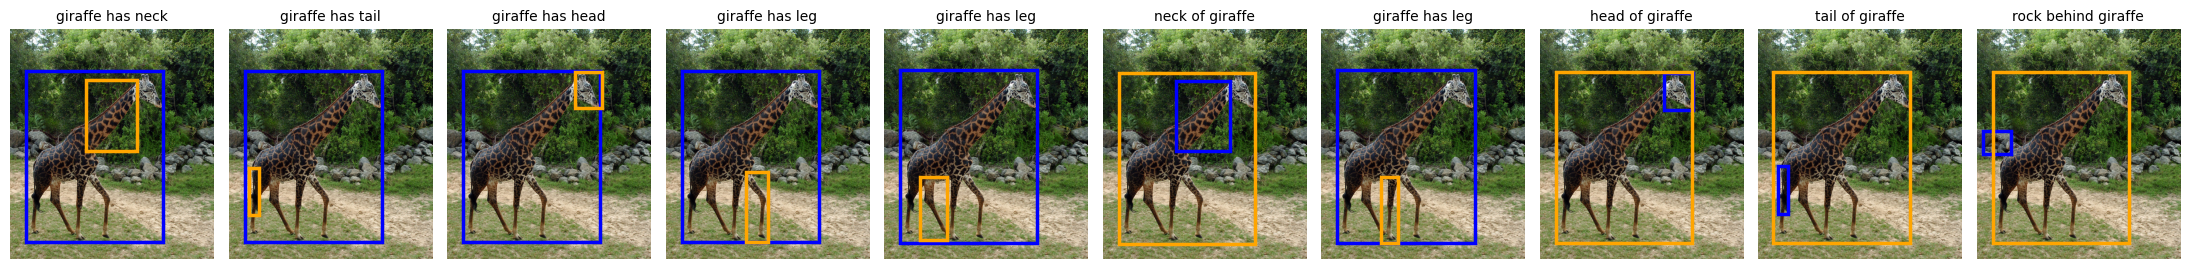

In [9]:
ort_session = onnxruntime.InferenceSession("normal_resolution-sim.onnx")

# compute ONNX Runtime output prediction
start = time.time()
ort_inputs = {ort_session.get_inputs()[0].name: img}
ort_outs = ort_session.run(None, ort_inputs)
print("inference time: ", time.time()-start)

post_processing(ort_outs)

inference time:  0.14322876930236816
Exported model has been tested with ONNXRuntime, and the result looks good!


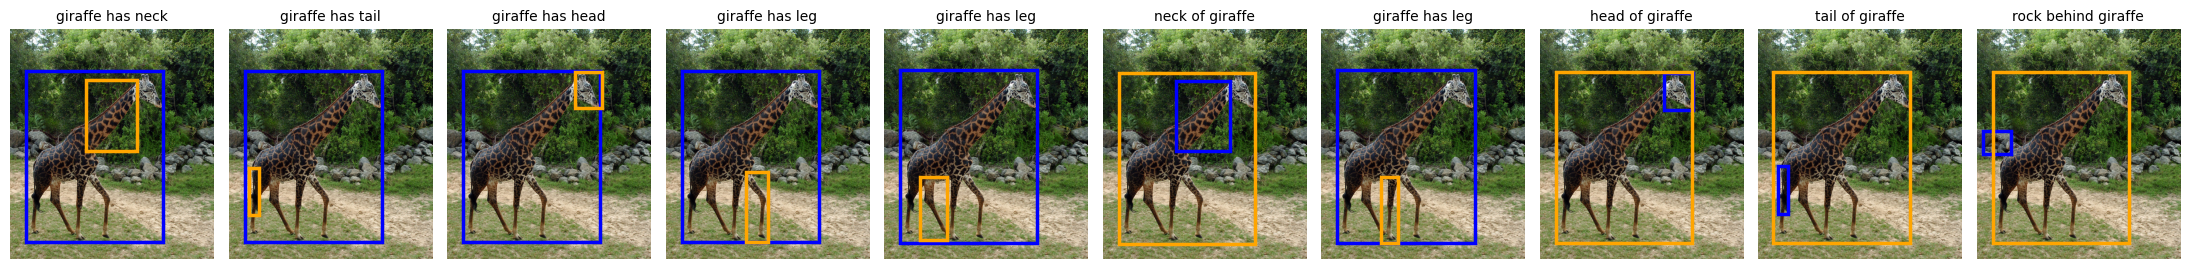

In [16]:
from deepsparse import compile_model
from deepsparse.utils import generate_random_inputs
onnx_filepath = "normal_resolution-sim.onnx"
batch_size = 1

# Compile and run
engine = compile_model(onnx_filepath, batch_size)

start = time.time()
outputs = engine.run([img])
print("inference time: ", time.time()-start)
post_processing(outputs)

# Quantization

In [11]:
def preprocess_image(image):
    np_image = np.array(image)
    np_image = np_image.transpose(2, 0, 1) # CxHxW
    mean_vec = np.array([0.485, 0.456, 0.406])
    std_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(np_image.shape).astype('float32')
    for i in range(np_image.shape[0]):
        norm_img_data[i,:,:] = (np_image[i,:,:]/255 - mean_vec[i])/std_vec[i]
             
    np_image = np.expand_dims(norm_img_data, axis=0) # 1xCxHxW
    return np_image

In [12]:
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import onnx

model_fp32 = "normal_resolution.onnx"
model_quant = "normal_resolution.quant.onnx"

onnx_opt_model = onnx.load(model_fp32)
quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8) #chnage QInt8 to QUInt8

Ignore MatMul due to non constant B: /[MatMul_756]
Ignore MatMul due to non constant B: /[MatMul_761]
Ignore MatMul due to non constant B: /[MatMul_885]
Ignore MatMul due to non constant B: /[MatMul_890]


KeyboardInterrupt: 

In [15]:
img_path = "demo/vg1.jpg"
im = Image.open(img_path)
img=transform(im).unsqueeze_(0).cpu().detach().numpy()

ort_session = onnxruntime.InferenceSession(model_quant)

# compute ONNX Runtime output prediction
start = time.time()
ort_inputs = {ort_session.get_inputs()[0].name: img}
ort_outs = ort_session.run(None, ort_inputs)
print("inference time: ", time.time()-start)

ort_session = onnxruntime.InferenceSession(model_fp32)

# compute ONNX Runtime output prediction
start = time.time()
ort_inputs = {ort_session.get_inputs()[0].name: img}
ort_outs = ort_session.run(None, ort_inputs)
print("inference time: ", time.time()-start)

#post_processing(ort_outs)

inference time:  0.24898815155029297
inference time:  0.12584400177001953


# Static quantization

In [ ]:
!python3.8 -m onnxruntime.quantization.shape_inference --input normal_resolution.onnx --output normal_resolution-infer.onnx

/home/maelic/miniconda3/envs/phd/lib/python3.8/runpy.py:127: RuntimeWarning: 'onnxruntime.quantization.shape_inference' found in sys.modules after import of package 'onnxruntime.quantization', but prior to execution of 'onnxruntime.quantization.shape_inference'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


# Optimize and simplify model

In [ ]:
!onnxsim normal_resolution.quant.onnx normal_resolution_sim.quant.onnx

Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                       ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add                   │ 598            │ 598              │
│ BatchNormalization    │ 2              │ 2                │
│ Cast                  │ 289            │ 289              │
│ Concat                │ 23             │ 23               │
│ ConvInteger           │ 56             │ 56               │
│ Div                   │ 125            │ 125              │
│ DynamicQuantizeLinear │ 221            │ 221              │
│ Gather                │ 7              │ 7                │
│ MatMul                │ 92             │ 92               │
│ MatMulInteger         │ 233            │ 233              │
│ MaxPool               │ 2              │ 2                │
│ Mul                   │ 672            │ 672              │
│ Pad                  

# Check validity of the model

In [ ]:
import onnx

# Preprocessing: load the ONNX model
model_path = 'normal_resolution.onnx'
onnx_model = onnx.load(model_path)

print('The model is:\n{}'.format(onnx_model))

# Check the model
try:
    onnx.checker.check_model(onnx_model)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid!')

In [ ]:
import onnx

# Preprocessing: load the ONNX model
model_path = 'normal_resolution-sim-quant.onnx'
onnx_model = onnx.load(model_path)

print('The model is:\n{}'.format(onnx_model))

# Check the model
try:
    onnx.checker.check_model(onnx_model)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid!')

In [9]:
sess_options = onnxruntime.SessionOptions()
#sess_options.enable_profiling = True

sess_options.intra_op_num_threads = 2
sess_options.execution_mode = onnxruntime.ExecutionMode.ORT_SEQUENTIAL
sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL

ort_session  = onnxruntime.InferenceSession("normal_resolution.onnx", sess_options)    

img_path = "demo/vg1.jpg"
im = Image.open(img_path)
img=transform(im).unsqueeze_(0).cpu().detach().numpy()

# compute ONNX Runtime output prediction
start = time.time()
ort_inputs = {ort_session.get_inputs()[0].name: img}
ort_outs = ort_session.run(None, ort_inputs)
print("inference time: ", time.time()-start)

inference time:  0.33001112937927246
